In [1]:
!pip install tensorflow_gpu==1.15

     |████████████████████████████████| 411.5MB 40kB/s 
     |████████████████████████████████| 512kB 42.4MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 3.8MB 50.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=822d54c436ba58dfb42fb0a538f9cb6da67a5cbf365ceff687cb45476f98cd38
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [2]:
import numpy as np
import tensorflow as tf
tf.__version__

'1.15.0'

In [3]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 5000  # 200000 to improve

# Number of evaluation steps.
#num_eval_steps = 50

MODELS_CONFIG = {
        'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'demo.config',
        'batch_size': 1
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `tensorflow-object-detection` repository or your fork.

In [4]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.84 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (412/412), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


In [5]:
!pip install tf_slim

     |████████████████████████████████| 358kB 7.9MB/s 


## Install required packages

In [ ]:
print()

In [6]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144599 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [7]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [8]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/data.record'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/demo.pbtxt'

## Download base model

In [9]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [10]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 24 root   root 4.0K Sep 15 12:18 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [11]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [12]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)
print(pipeline_fname)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

/content/models/research/object_detection/samples/configs/demo.config


In [13]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [14]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    
    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [15]:
!cat {pipeline_fname}

model {
  faster_rcnn {
    num_classes: 4
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        random_normal_initializer {
              mean: 1 
	stddev: 0.5
            }
        }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel

In [16]:
pwd

'/content/models/research'

In [17]:
train_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {train_dir}
os.makedirs(train_dir, exist_ok=True)

In [ ]:
pwd

'/content/models/research'

## Train the model

In [18]:
print("Training the model")

Training the model


In [19]:
!python /content/models/research/object_detection/legacy/train.py --pipeline_config_path=/content/models/research/object_detection/samples/configs/demo.config --train_dir=/content/models/research/training/ --alsologtostderr

Streaming output truncated to the last 5000 lines.
I0915 12:28:20.203388 140345985947520 learning.py:512] global step 2511: loss = 0.0050 (0.170 sec/step)
INFO:tensorflow:global step 2512: loss = 0.0095 (0.153 sec/step)
I0915 12:28:20.358258 140345985947520 learning.py:512] global step 2512: loss = 0.0095 (0.153 sec/step)
INFO:tensorflow:global step 2513: loss = 0.0071 (0.171 sec/step)
I0915 12:28:20.531068 140345985947520 learning.py:512] global step 2513: loss = 0.0071 (0.171 sec/step)
INFO:tensorflow:global step 2514: loss = 0.0086 (0.157 sec/step)
I0915 12:28:20.689172 140345985947520 learning.py:512] global step 2514: loss = 0.0086 (0.157 sec/step)
INFO:tensorflow:global step 2515: loss = 0.0242 (0.159 sec/step)
I0915 12:28:20.849264 140345985947520 learning.py:512] global step 2515: loss = 0.0242 (0.159 sec/step)
INFO:tensorflow:global step 2516: loss = 0.0104 (0.157 sec/step)
I0915 12:28:21.008000 140345985947520 learning.py:512] global step 2516: loss = 0.0104 (0.157 sec/step)


In [21]:
!ls {train_dir}

checkpoint
events.out.tfevents.1600172479.85e477e76d4a
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-3631.data-00000-of-00001
model.ckpt-3631.index
model.ckpt-3631.meta
model.ckpt-5000.data-00000-of-00001
model.ckpt-5000.index
model.ckpt-5000.meta
pipeline.config


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [22]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(train_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(train_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-5000
Instructions for updating:
Please use `layer.__call__` method instead.
W0915 12:37:59.117402 139682856511360 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0915 12:38:00.401423 139682856511360 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0915 12:38:00.546267 139682856511360 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0915 12:38:00.546708 139682856511360 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0915 12:38:00.600987 

In [23]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [24]:
pwd

'/content/models/research'

## Download the model `.pb` file

In [25]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [26]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 50M Sep 15 12:38 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [43]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

KeyboardInterrupt: ignored

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [38]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test

To test on your own images, you need to upload raw test images to the `test` folder located inside `/data`.

Right now, this folder contains TFRecord files from Roboflow. We need the raw images.


#### Add test images to this notebook

We can download the exact same raw images that are in our Roboflow test split to our local computer by downloading the images in a different (non-TFRecord) format.

Go back to our [dataset](https://public.roboflow.ai/object-detection/bccd/1), click "Download," select "COCO JSON" as the format, and download to your local machine.

Unzip the downloaded file, and navigate to the `test` directory.
![folder](https://i.imgur.com/xkjxmKP.png)


Now, on the left-hand side in the colab notebook, select the folder icon.
![Colab folder](https://i.imgur.com/59v08qG.png)

Right-click on `test`, and select "Upload." Navigate to the files locally on your machine you just downloaded...and voila! You're set!


In [27]:
# optionally, remove the TFRecord and cells_label_map.pbtxt from
# the test directory so it is only raw images
%cd {repo_dir_path}
%cd data/test
%rm cells.tfrecord
%rm cells_label_map.pbtxt

/content/tensorflow-object-detection-faster-rcnn
/content/tensorflow-object-detection-faster-rcnn/data/test
rm: cannot remove 'cells.tfrecord': No such file or directory
rm: cannot remove 'cells_label_map.pbtxt': No such file or directory


In [28]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_117_18 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_113_16 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/0001 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_107_13 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_100_9 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_45 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_104_12 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/agustiner-20200314_page-0001 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_120_20 resized.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/Invoice_102_10 resized.jpg']


In [29]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [30]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.1), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [31]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

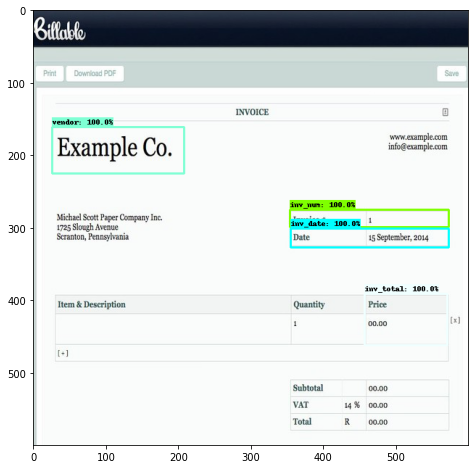

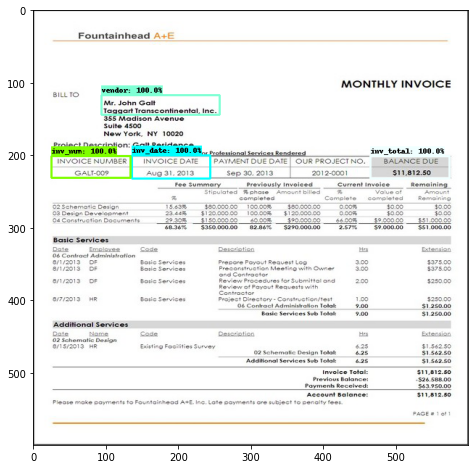

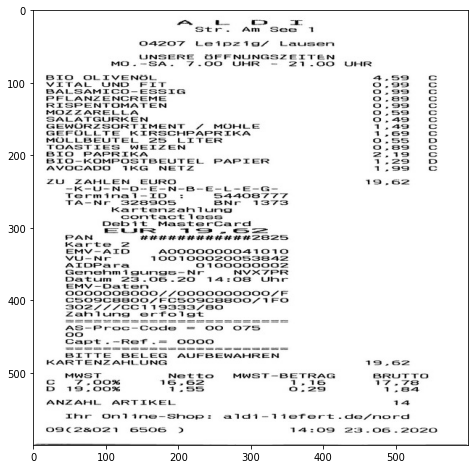

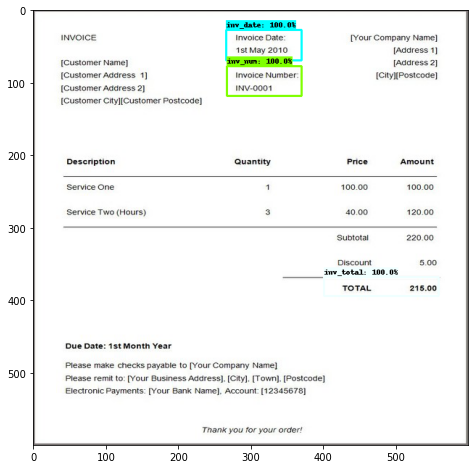

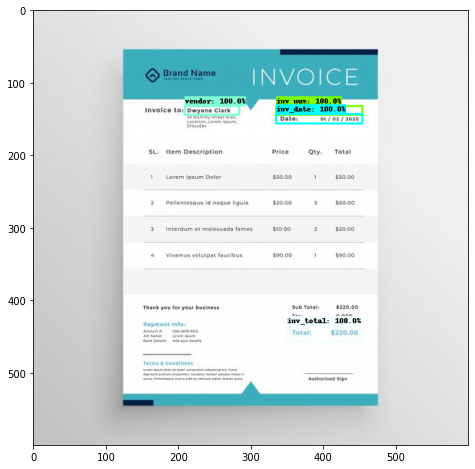

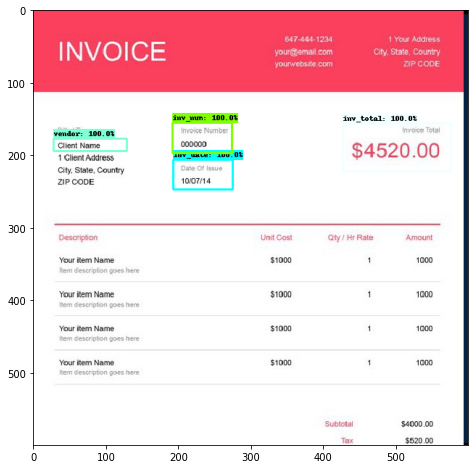

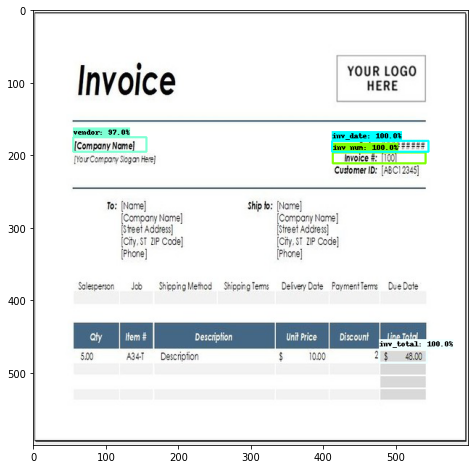

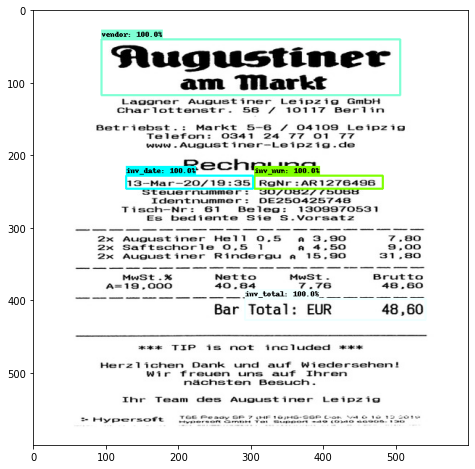

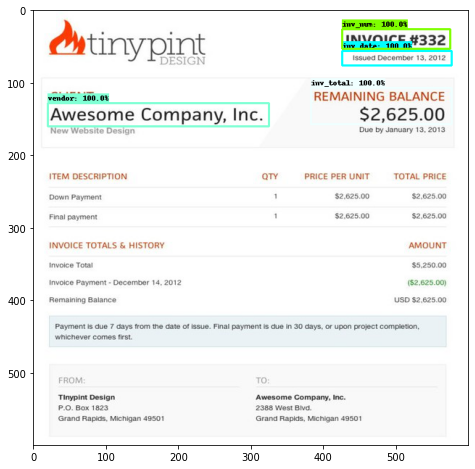

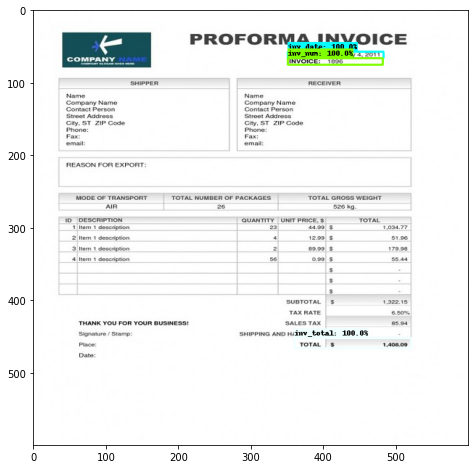

In [33]:

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=3)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [34]:
!mkdir -p /content/sample_data/InvoiceDataExtraction/data/output/

In [37]:
!python /content/sample_data/InvoiceDataExtraction/code/bbox_detection.py \
       --model /content/models/research/fine_tuned_model/frozen_inference_graph.pb \
       --label_map /content/tensorflow-object-detection-faster-rcnn/data/demo.pbtxt \
       --image /content/tensorflow-object-detection-faster-rcnn/data/test \
       --outputImage /content/sample_data/InvoiceDataExtraction/data/output \
       --outputJson /content/sample_data/InvoiceDataExtraction/data/output/

Invoice_117_18 resized



2020-09-15 12:56:17.263240: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-09-15 12:56:17.268213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 12:56:17.268707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-09-15 12:56:17.268988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-09-15 12:56:17.270206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-09-15 12:56:17.271322: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic 

In [39]:
!ls -lrt /content/sample_data/InvoiceDataExtraction/data/output/

total 500
-rw-r--r-- 1 root root   562 Sep 15 12:56 'Invoice_117_18 resized.json'
-rw-r--r-- 1 root root 33521 Sep 15 12:56 'Invoice_117_18 resized.jpg'
-rw-r--r-- 1 root root 62223 Sep 15 12:56 'Invoice_113_16 resized.jpg'
-rw-r--r-- 1 root root   567 Sep 15 12:56 'Invoice_113_16 resized.json'
-rw-r--r-- 1 root root   263 Sep 15 12:56 '0001 resized.json'
-rw-r--r-- 1 root root 70242 Sep 15 12:56 '0001 resized.jpg'
-rw-r--r-- 1 root root   569 Sep 15 12:56 'Invoice_107_13 resized.json'
-rw-r--r-- 1 root root 38120 Sep 15 12:56 'Invoice_107_13 resized.jpg'
-rw-r--r-- 1 root root   566 Sep 15 12:56 'Invoice_100_9 resized.json'
-rw-r--r-- 1 root root 28557 Sep 15 12:56 'Invoice_100_9 resized.jpg'
-rw-r--r-- 1 root root 33710 Sep 15 12:56 'Invoice_45 resized.jpg'
-rw-r--r-- 1 root root 40362 Sep 15 12:56 'Invoice_104_12 resized.jpg'
-rw-r--r-- 1 root root   567 Sep 15 12:56 'Invoice_104_12 resized.json'
-rw-r--r-- 1 root root   565 Sep 15 12:56 'agustiner-20200314_page-0001 resized.json'
-

In [ ]:
%load_ext tensorboard

In [ ]:
%cd /content/models/research/

%tensorboard --logdir "training"

/content/models/research


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# for OCR from JSON files 
import json
import os
import numpy as np
#import pytesseract
from pytesseract import *
from PIL import Image
from pytesseract import Output
import cv2
import pandas as pd
# from StyleFrame import StyleFrame
import re
from dateparser.search import search_dates
import pandas as pd
from glob import glob
from datetime import datetime
from PIL import Image
import argparse
import xlsxwriter


ModuleNotFoundError: ignored